# HW 4
written by JungYoung<br/>
Last updated, 201017

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import ElecField_mc as em
import tqdm
import cv2

In [3]:
class SolveODE_elec:
    def __init__(self, pos, rhos, vol, target_q):
        self.rhos = rhos
        self.pos = pos
        self.vol = vol
        self.target_q = target_q

    def F_e(self, x):
        return self.target_q * em.get_elecfield(self.pos, self.rhos, x.reshape(2, 1), vol=self.vol, k=1)[:, 0]

    def f(self, x, v, F):
        # dv/dt = F(x)
        # dx/dt = v
        dv = self.F_e(x)*self.dt
        dx = (v+dv)*self.dt
        return dx, dv

    def solve(self, x, v, tmax, rmax=None, dt=0.01):
        itr = int(tmax/dt)
        self.x = np.array(x)
        self.v = np.array(v)
        self.dt = dt
        self.xs = [self.x.copy()]
        self.vs = [self.v.copy()]
        pbar = tqdm.tqdm(range(itr), ncols=100)
        for i in pbar:
            self.update()
            self.xs.append(self.x.copy())
            self.vs.append(self.v.copy())
            if rmax is not None and np.sqrt(sum(self.x**2)) <= rmax:
                print('\ncollision occur!')
                pbar.close()
                break
        self.xs = np.array(self.xs)
        self.vs = np.array(self.vs)

    def update(self):
        # use RK4 method
        kdx1, kdv1 = self.f(self.x, self.v, self.F_e(self.x))
        kdx2, kdv2 = self.f(self.x+kdx1/2, self.v+kdx1/2, self.F_e(self.x+kdx1/2))
        kdx3, kdv3 = self.f(self.x+kdx2/2, self.v+kdv2/2, self.F_e(self.x+kdx2/2))
        kdx4, kdv4 = self.f(self.x+kdx3, self.v+kdv3, self.F_e(self.x+kdx3))
        self.x += kdx1/6+kdx2/3+kdx3/3+kdx4/6
        self.v += kdv1/6+kdv2/3+kdv3/3+kdv4/6
        

class PickRand(em.mcSampling):
    def frho(self, r):
        # k*|r|**2
        return 2*sum(r**2)

    def fboundary(self, r):
        # rmax = 1
        return np.sqrt(sum(r**2)) <= 1

# figures
def draw_fig(n, obj, pts, rho, Vmap, xlim, ylim, axs, fig, w=0.5):
    axs[0].cla()
    # draw circle
    circle = plt.Circle((0, 0), rmax, color='k')
    axs[0].add_artist(circle)
    # draw potential map
    axs[0].imshow(Vmap, extent=(*xlim, *ylim), cmap='jet', vmax=2)
    # draw target charge
    axs[0].plot(obj.xs[n, 0], obj.xs[n, 1], 'bo', ms=8, markeredgecolor='k')
    # draw velocity arrow
    axs[0].arrow(obj.xs[n, 0], obj.xs[n, 1], obj.vs[n, 0], obj.vs[n, 1],
                capstyle='butt', head_width=0.1, linewidth=1.2, overhang=0.3, ec='w')
    # set label & lim
    axs[0].set_xlim(xlim)
    axs[0].set_ylim(ylim)
    axs[0].set_xticks([xlim[0], 0, xlim[1]])
    axs[0].set_yticks([ylim[0], 0, ylim[1]])
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    ######## ax2
    axs[1].cla()
    # get variables
    x1 = np.linspace(obj.xs[n, 0]-w, obj.xs[n, 0]+w, 31)
    y1 = np.ones(x1.shape) * obj.xs[n, 1]
    V1 = em.get_potfield(pts, rho, np.array([x1, y1]), vol=vol, k=1)
    ix = int((x1.shape[0]-1)/2) # get center
    xl = (obj.xs[n, 0]-w, obj.xs[n, 0]+w)
    yl = get_ylim(V1, 2)
    # plot variables
    axs[1].plot(x1, V1, 'k', lw=0.8)
    axs[1].plot(np.ones(2)*x1[ix], yl, 'r--', lw=0.5)
    axs[1].plot(xl, np.ones(2)*V1[ix], 'r--', lw=0.5)
    axs[1].scatter(x1[ix], V1[ix], s=10, c='b')
    # set label props
    axs[1].set_xlim(xl)
    axs[1].set_ylim(yl)
    axs[1].set_xticks((obj.xs[n, 0]-w, obj.xs[n, 0], obj.xs[n, 0]+w))
    axs[1].set_yticks([yl[0], np.round(V1[ix], 2), yl[1]])
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('potential')
    ######## ax3
    axs[2].cla()
    # get variable
    y2 = np.linspace(obj.xs[n, 1]-w, obj.xs[n, 1]+w, 31)
    x2 = np.ones(y2.shape) * obj.xs[n, 0]
    V2 = em.get_potfield(pts, rho, np.array([x2, y2]), vol=vol, k=1)
    iy = int((x2.shape[0]-1)/2)
    xl = (obj.xs[n, 1]-w, obj.xs[n, 1]+w)
    yl = get_ylim(V2, 2)
    # set label props
    axs[2].plot(y2, V2, 'k', lw=0.8)
    axs[2].plot(np.ones(2)*y2[iy], yl, 'r--', lw=0.5)
    axs[2].plot(xl, np.ones(2)*V2[iy], 'r--', lw=0.5)
    axs[2].scatter(y1[iy], V2[iy], s=10, c='b')
    # set label props
    axs[2].set_xlim(xl)
    axs[2].set_ylim(yl)
    axs[2].set_xticks([obj.xs[n, 1]-w, obj.xs[n, 1], obj.xs[n, 1]+w])
    axs[2].set_yticks([yl[0], np.round(V2[iy], 2), yl[1]])
    axs[2].set_xlabel('y')
    axs[2].set_ylabel('potential')
    return axs, fig


def get_ylim(y, decimals):
    ymax = np.round(max(y), decimals=decimals)
    if ymax < max(y):
        ymax += 10**(-decimals)
    ymin = np.round(min(y), decimals=decimals)
    if ymin > min(y):
        ymin -= 10**(-decimals)
    return [ymin, ymax]

def figure_to_array(fig):
    # fig.canvas.draw()
    return np.array(fig.canvas.renderer._renderer)

    

In [4]:
# get electric field 
seed = 100010
rmax = 1
rlim = [[-rmax, rmax], [-rmax, rmax]]
itr = 1e5
vol = np.pi*rmax**2 / itr
mc_obj = PickRand(rlim, ndim=2, seed=seed)

In [5]:
pts, rho = mc_obj.get_rand_pts(itr=int(itr))

100%|████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 60682.87it/s]


In [6]:
ode_obj = SolveODE_elec(pts, rho, vol, -1)

In [7]:
# initial condition
# set x = [10, 0]
# set v = [0, 0]
x_init = [0., 2.]
v_init = [0., 0]
dt = 0.001
ode_obj.solve(x_init, v_init, 10, rmax, dt=dt)

 13%|███████▋                                                  | 1315/10000 [01:01<06:43, 21.52it/s]
collision occur!



## Create animation

In [8]:
xlim = [-5, 5]
ylim = [-5, 5]
res = [1200, 800]
dpi = 200

In [9]:
# init figure
# get potential map
tmp_x = np.linspace(xlim[0], xlim[1], 100)
tmp_y = np.linspace(ylim[0], ylim[1], 100)
X, Y = np.meshgrid(tmp_x, tmp_y)
ind_bd = np.sqrt(X**2 + Y**2) < rmax-0.1
X[ind_bd] = np.nan
Y[ind_bd] = np.nan
Vmap = em.get_potfield(pts, rho, np.array([X.flatten(), Y.flatten()]), vol=vol, k=1)
Vmap = Vmap.reshape(X.shape)

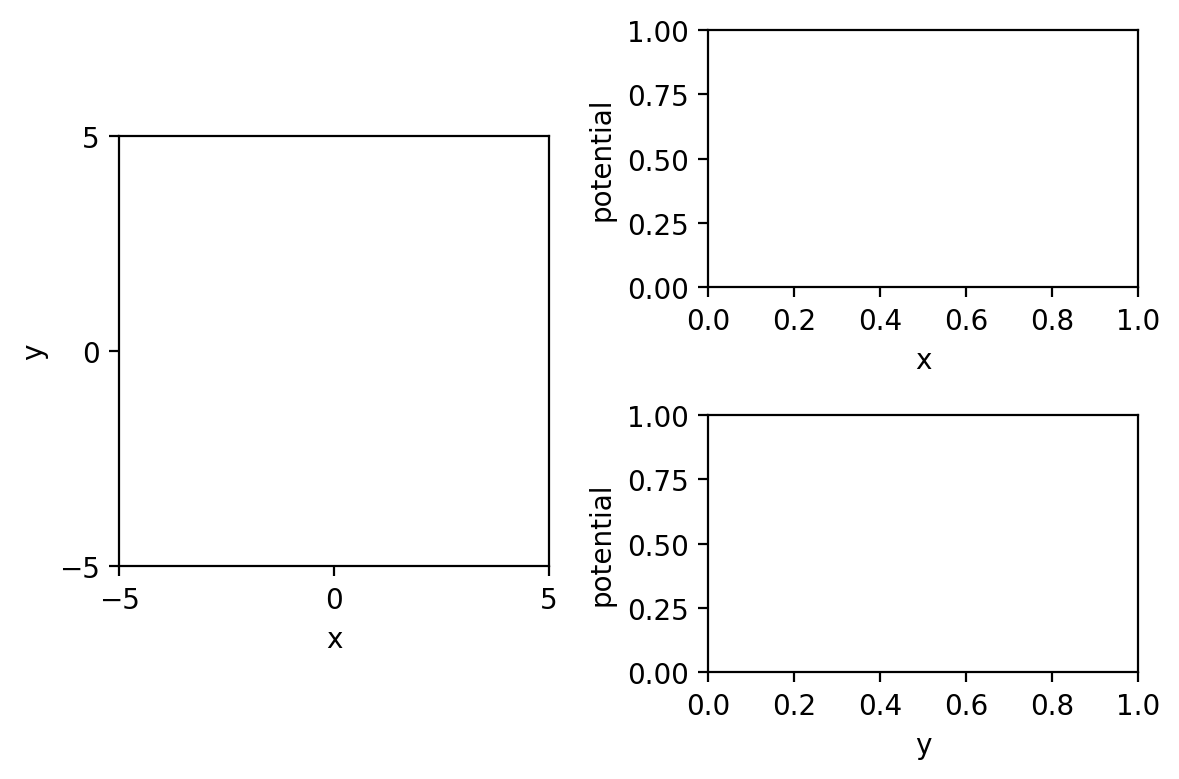

In [13]:
fig = plt.figure(dpi=dpi, figsize=(res[0]/dpi, res[1]/dpi))
ax1 = plt.subplot(1,2,1)
# set figure
# plt.imshow(Vall, extent=(*xlim, *ylim), cmap='jet', vmax=2)
ax1.axis('square')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xticks([xlim[0], 0, xlim[1]])
plt.yticks([ylim[0], 0, ylim[1]])
plt.xlabel('x')
plt.ylabel('y')
# plot center
# plot target charge
# p_charge, = plt.plot(np.nan, np.nan, 'bo', ms=8, markeredgecolor='k')
# set ax2,3
# second axis
ax_x = plt.subplot(222)
ax_x.set_xlabel('x')
ax_x.set_ylabel('potential')
# third axis
ax_y = plt.subplot(224)
ax_y.set_xlabel('y')
ax_y.set_ylabel('potential')
plt.tight_layout()
# plt.show()

axs = [ax1, ax_x, ax_y]
# print('init figure')

In [37]:
FPS = 60
tmax = ode_obj.xs.shape[0] * ode_obj.dt
n_itr = int(tmax * FPS)+1
70 / FPS / ode_obj.dt


1317 1.317
80


1166.6666666666667

In [38]:
2 / FPS / ode_obj.dt

33.333333333333336

In [41]:
# save
video = cv2.VideoWriter('./test.mp4', cv2.VideoWriter_fourcc(*'DIVX'), FPS, (1200, 800))
os.mkdir('./tmp')
for i in tqdm.tqdm(range(n_itr)):
    if i < n_itr-1:
        n = int(i / FPS / ode_obj.dt)
    else:
        n = ode_obj.xs.shape[0]-1
    axs, fig = draw_fig(n, ode_obj, pts, rho, Vmap, xlim, ylim, axs, fig)
    fig.canvas.draw()
    fig.savefig('./tmp/%d.png'%(i), format='png', dpi=200)
    # read image
    im = cv2.imread('./tmp/%d.png'%(i))
    im = cv2.resize(im, (1200, 800))
    video.write(im)
    os.remove('./tmp/%d.png'%(i))
video.release()
os.rmdir('./tmp/')
print('\ndone')

100%|██████████| 80/80 [00:47<00:00,  1.67it/s]
done

